# Predicting the requests for which loans were awarded
The project will include following tasks:
- Loading dataset
- Cleaning up the data:
    - Encode replace missing values
    - Replace features values that appear incorrect
- Encode categorical variables
- Split dataset to Train/Test/Validation
- Add engineered features
- Train and tune ML model
- Provide final metrics using Validation dataset
- Writing functions that could dump the model and load the encoding processes so they could be used independently, without the need to retrain the model

## Dataset description
The dataset for Lab-2 is sample of the SBA dataset posted on Kaggle.
The dataset is from the U.S. Small Business Administration (SBA) The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment. There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.  
More info on the original dataset: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied

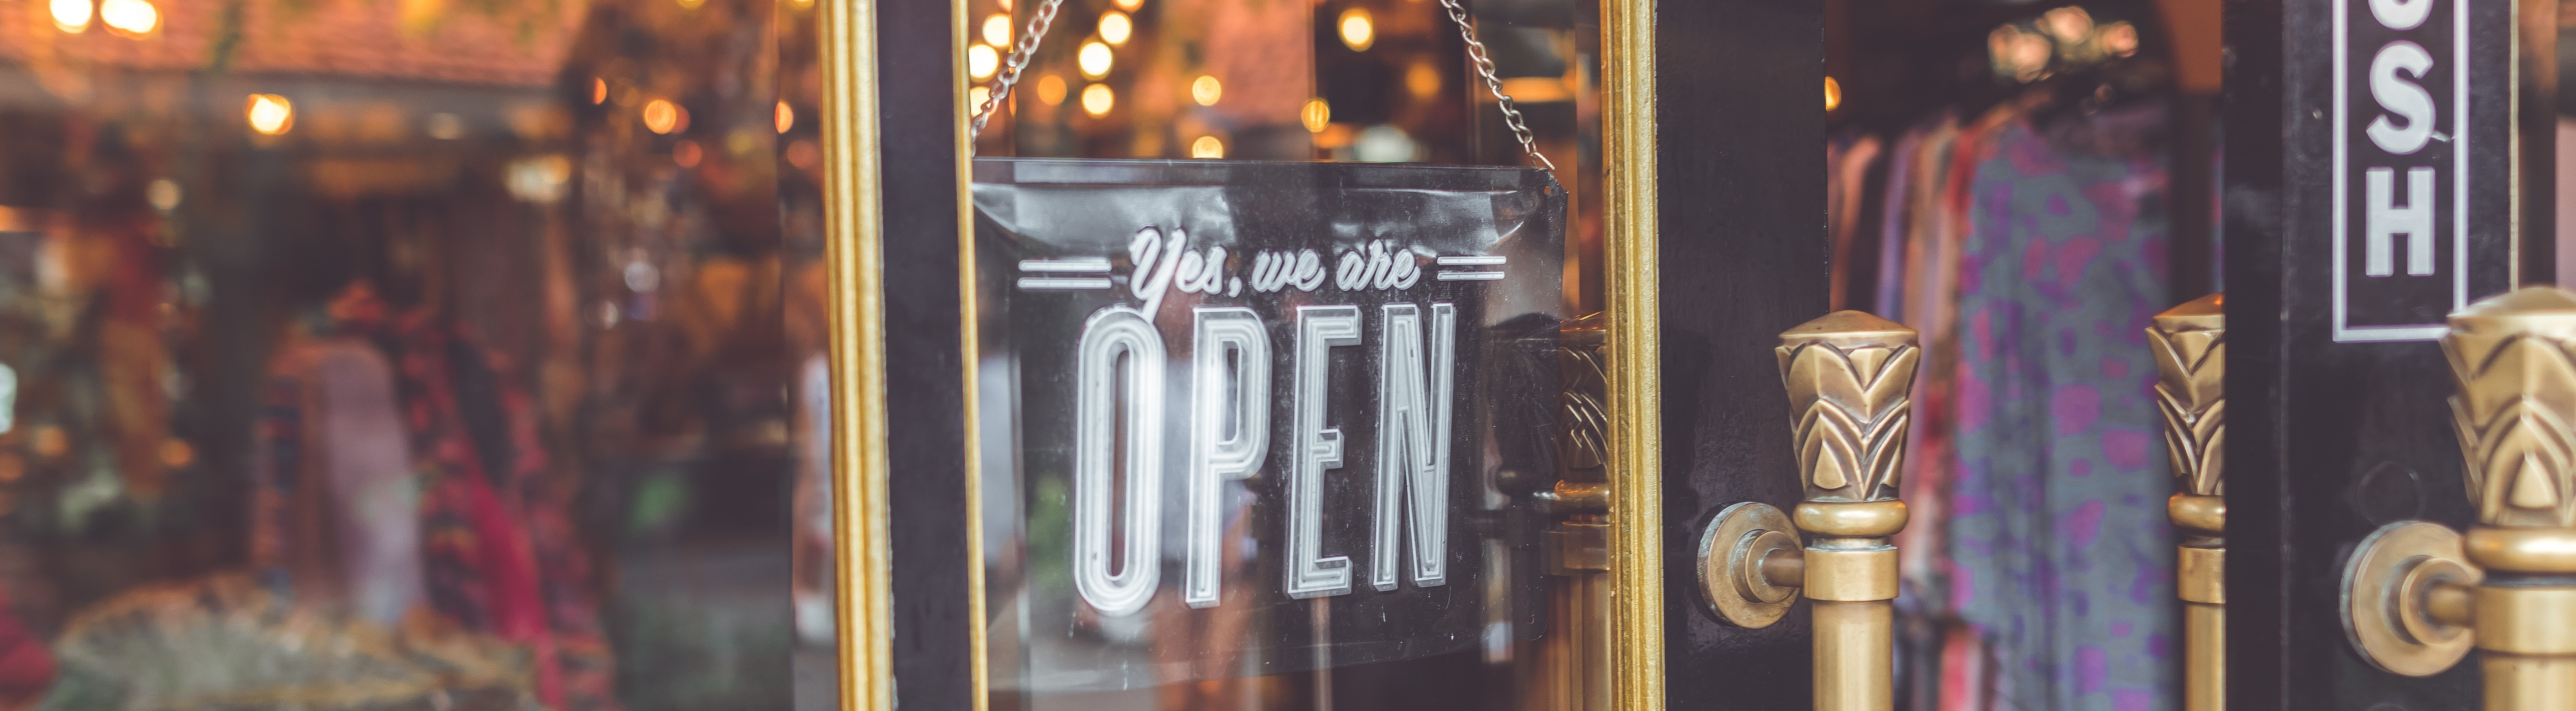

In [72]:
from IPython import display
display.Image("./data/small_busineses.jpg")

## Preparation

In [1]:
import numpy as np
import pandas as pd
import pickle
import dill
pd.set_option('display.max_columns', 1500)
# set seed for reproducibility
np.random.seed(123)


import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Load data

In [2]:
data = pd.read_csv('./data/SBA_loans_project_1.zip')

In [3]:
print("Data shape:", data.shape)

Data shape: (809247, 20)


**Review dataset**

In [4]:
data.head(n=10)

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,GLEN BURNIE,MD,21060,"BUSINESS FINANCE GROUP, INC.",VA,811111,240,7,1.0,6,7,1,1,0,N,"$743,000.00",$0.00,"$743,000.00","$743,000.00",P I F
1,WEST BEND,WI,53095,JPMORGAN CHASE BANK NATL ASSOC,IL,722410,240,20,1.0,0,0,1,0,N,N,"$137,000.00",$0.00,"$137,000.00","$109,737.00",P I F
2,SAN DIEGO,CA,92128,UMPQUA BANK,OR,0,120,2,1.0,0,0,1,0,0,N,"$280,000.00",$0.00,"$280,000.00","$210,000.00",P I F
3,WEBSTER,MA,1570,HOMETOWN BANK A CO-OPERATIVE B,MA,621310,84,7,1.0,0,0,1,1,0,Y,"$144,500.00",$0.00,"$144,500.00","$122,825.00",P I F
4,JOPLIN,MO,64804,U.S. BANK NATIONAL ASSOCIATION,OH,0,60,2,2.0,0,0,1,0,N,Y,"$52,500.00",$0.00,"$52,500.00","$42,000.00",P I F
5,NEWTOWN,OH,45244,HAMILTON CNTY DEVEL COMPANY IN,OH,234110,240,5,1.0,2,0,1,0,N,N,"$52,000.00",$0.00,"$52,000.00","$52,000.00",P I F
6,MISSION VIEJO,CA,92691,BANK OF AMERICA CALIFORNIA N.A,CA,445310,60,3,1.0,0,0,1,0,Y,N,"$50,000.00",$0.00,"$50,000.00","$25,000.00",P I F
7,OSWEGO,IL,60543,JPMORGAN CHASE BANK NATL ASSOC,IL,812990,57,1,1.0,2,1,0,1,Y,N,"$38,619.00",$0.00,"$25,000.00","$12,500.00",CHGOFF
8,DECATUR,GA,30033,WELLS FARGO BANK NATL ASSOC,SD,561421,71,10,1.0,1,11,1,1,Y,N,"$32,714.00",$0.00,"$20,000.00","$10,000.00",CHGOFF
9,ROLLING HILLS,CA,90274,BANC OF CALIFORNIA NATL ASSOC,CA,541512,84,4,1.0,4,4,1,1,Y,N,"$90,055.00",$0.00,"$50,000.00","$25,000.00",P I F


## Dataset preparation and clean-up

Modifying and cleaning-up the dataset as following:
- Replacing and encoding Na/Null values
- Converting the strings styled as '$XXXX.XX' to float values.
- Convert MIS_Status to 0/1. Make value "CHGOFF" as 1

In [5]:
# colomn type
data.dtypes

City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
MIS_Status            object
dtype: object

In [6]:
# mapping MIS_Status to 0/1
data['MIS_Status'] = data['MIS_Status'].replace({'CHGOFF': 1, 'P I F': 0}).astype(float)

In [7]:
%%time
# converting monetary values from string to float
data['DisbursementGross'] = data['DisbursementGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['BalanceGross'] = data['BalanceGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['GrAppv'] = data['GrAppv'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['SBA_Appv'] = data['SBA_Appv'].replace({'\$': '', ',': ''}, regex=True).astype(float)

Wall time: 15.6 s


In [8]:
# replace Na/Null values
values_to_fill = {}
for col in data.drop(columns=['MIS_Status']).columns:
    if data[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

data.fillna(value=values_to_fill,inplace=True)

In [9]:
# drop rows with missing values
data.dropna(inplace=True)

In [10]:
# list columns with missing values
sum(data.isnull().any())

0

In [11]:
# wheter the bank and customer are in the same state
data['state_and_bankstate'] = np.where(data['State'] == data['BankState'], 1, 0)
# The difference between initial approved amount and final amount of loan
data['diff_loan_amt1'] = data['GrAppv'] - data['SBA_Appv']
# The difference between approved amount of loan and the requested amount of loan
data['diff_loan_amt2'] = data['DisbursementGross'] - data['SBA_Appv']
# amount of instalment
data['instalment'] = np.where(data['Term'] == 0, data['SBA_Appv'], data['SBA_Appv']/data['Term'])

#### Splitting the dataset to test and train

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [13]:
train.shape , test.shape

((565197, 24), (242228, 24))

In [14]:
train.iloc[:,13].value_counts(sort=True)

N          264602
0          162054
Y          126160
T            9491
Missing      2851
1              13
R              10
`               5
2               4
C               2
.               1
7               1
-               1
3               1
A               1
Name: RevLineCr, dtype: int64

In [15]:
values_to_keep = ['N', 'Y' , 'Missing' , '0' , 'T' ]
train.iloc[:,13][~data.iloc[:,13].isin(values_to_keep)] = 'Missing'
test.iloc[:,13][~data.iloc[:,13].isin(values_to_keep)] = 'Missing'

In [16]:
test.iloc[:,13].value_counts(sort=True)

N          112885
0           69758
Y           54169
T            4162
Missing      1254
Name: RevLineCr, dtype: int64

In [17]:
data.iloc[:,14].value_counts(sort=True)

N          702853
Y           99186
Missing      2315
0            1343
C             681
S             534
A             447
R              65
1               1
Name: LowDoc, dtype: int64

In [18]:
train.iloc[:,14].value_counts(sort=True)

N          491970
Y           69421
Missing      1646
0             941
C             486
S             372
A             313
R              48
Name: LowDoc, dtype: int64

In [19]:
values_to_keep = ['N', 'Y' , 'Missing' , '0' , 'C' , 'S', 'A' , 'R' ]
train.iloc[:,14][~data.iloc[:,14].isin(values_to_keep)] = 'Missing'
test.iloc[:,14][~data.iloc[:,14].isin(values_to_keep)] = 'Missing'

In [20]:
test.iloc[:,14].value_counts(sort=True)

N          210883
Y           29765
Missing       670
0             402
C             195
S             162
A             134
R              17
Name: LowDoc, dtype: int64

## Categorical variables encoding

Encoded the categorical data, using one-hot encoding, target encoding and

In [21]:
X_train = train.drop(columns='MIS_Status')
y_train = train['MIS_Status']
X_test = test.drop(columns='MIS_Status')
y_test = test['MIS_Status']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((565197, 23), (565197,), (242228, 23), (242228,))

In [22]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from copy import deepcopy

'''Save original columns that need to be droped or not used
   Save One-hot and Label encoders for future use
'''
#Columns to drop from ML models
cols_to_drop = []
#Categorical encoders disctionary
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []

for col in X_train.columns:
  if X_train[col].dtype == 'object':
    if X_train[col].nunique() < 10:
        print("One-hot encoding of ", col)
        enc = OneHotEncoder( handle_unknown='ignore', sparse=False)
        enc.fit(X_train[[col]])
        result = enc.transform(X_train[[col]])
        ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
        cat_enc_columns = cat_enc_columns + ohe_columns
        result_train = pd.DataFrame(result, columns=ohe_columns , index=X_train.index)
        X_train = pd.concat([X_train, result_train.reindex(X_train.index)], axis=1 , join='inner')
        '''Encode Testing'''
        result = enc.transform(X_test[[col]])
        result_test = pd.DataFrame(result, columns=ohe_columns , index=X_test.index)
        X_test = pd.concat([X_test, result_test.reindex(X_test.index)], axis=1 , join='inner')
        cat_encoders[col] = [deepcopy(enc),"ohe"]
    else:
        print("Target Encoding of ", col)
        enc = TargetEncoder()
        enc.fit(X_train[col] , y = y_train , handle_unknown='value' )
        pickle.dump(enc, open(col+'_trg_'+'pre_processing.p', "wb"))
        new_col_name = col+"_trg"
        X_train[new_col_name] = enc.transform(X_train[[col]])
        X_test[new_col_name] = enc.transform(X_test[[col]])
        cat_encoders[col] = [deepcopy(enc),"trg"]
        cat_enc_columns.append(new_col_name)


    cols_to_drop.append(col)

Target Encoding of  City
Target Encoding of  State
Target Encoding of  Bank
Target Encoding of  BankState
One-hot encoding of  RevLineCr
One-hot encoding of  LowDoc


In [23]:
from sklearn.preprocessing import MinMaxScaler
num_scalers = {}
'''Scale only original columns'''
for col in X_train.columns[0:23]:
    if X_train[col].dtype != 'object':
        print("MinMax scale of ", col)
        scaler = MinMaxScaler()
        scaler.fit(X_train[[col]])
        pickle.dump(scaler, open(col+'_sc_'+'pre_processing.p', "wb"))
        X_train[col+"_sc"] = scaler.transform(X_train[[col]])
        X_test[col+"_sc"] = scaler.transform(X_test[[col]])

        num_scalers[col] = [deepcopy(scaler),"MinMax"]
        cols_to_drop.append(col)

MinMax scale of  Zip
MinMax scale of  NAICS
MinMax scale of  Term
MinMax scale of  NoEmp
MinMax scale of  NewExist
MinMax scale of  CreateJob
MinMax scale of  RetainedJob
MinMax scale of  FranchiseCode
MinMax scale of  UrbanRural
MinMax scale of  DisbursementGross
MinMax scale of  BalanceGross
MinMax scale of  GrAppv
MinMax scale of  SBA_Appv
MinMax scale of  state_and_bankstate
MinMax scale of  diff_loan_amt1
MinMax scale of  diff_loan_amt2
MinMax scale of  instalment


# Model Training
Trained the model using following classifiers
- Logistic regression
- SVM
- Decision Tree
- LightGBM


In [24]:
X_tr = X_train.iloc[:,23:]
X_ts = X_test.iloc[:,23:]

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [26]:
%%time
logreg = LogisticRegression(C=1.0 , max_iter=100,  n_jobs= -1,
                            penalty= 'elasticnet' , l1_ratio=0.5,
                            solver= 'saga')
logreg.fit(X_tr, y_train)
# print logreg accuracy score, confusion matrix and auc score
print("Logistic Regression Accuracy Score: ", logreg.score(X_tr, y_train))
print("Logistic Regression Accuracy Score: ", logreg.score(X_ts, y_test))
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_train, logreg.predict(X_tr))/X_tr.shape[0])
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test, logreg.predict(X_ts))/X_ts.shape[0])
print("Logistic Regression AUC Score: ", roc_auc_score(y_train, logreg.predict_proba(X_tr)[:,1]))
print("Logistic Regression AUC Score: ", roc_auc_score(y_test, logreg.predict_proba(X_ts)[:,1]))

Logistic Regression Accuracy Score:  0.8711829680624632
Logistic Regression Accuracy Score:  0.8630917978103274
Logistic Regression Confusion Matrix: 
 [[0.80074027 0.02370678]
 [0.10511025 0.0704427 ]]
Logistic Regression Confusion Matrix: 
 [[0.79808693 0.02593424]
 [0.11097396 0.06500487]]
Logistic Regression AUC Score:  0.8656363436123631
Logistic Regression AUC Score:  0.8498370073947935
Wall time: 22.7 s


In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
%%time
dtree = DecisionTreeClassifier(max_depth=6)
dtree.fit(X_tr, y_train)
# print dtree accuracy score, confusion matrix and auc score
print("Decision Tree Accuracy Score: ", dtree.score(X_tr, y_train))
print("Decision Tree Accuracy Score: ", dtree.score(X_ts, y_test))
print("Decision Tree Confusion Matrix: \n", confusion_matrix(y_train, dtree.predict(X_tr))/X_tr.shape[0])
print("Decision Tree Confusion Matrix: \n", confusion_matrix(y_test, dtree.predict(X_ts))/X_ts.shape[0])
print("Decision Tree AUC Score: ", roc_auc_score(y_train, dtree.predict_proba(X_tr)[:,1]))
print("Decision Tree AUC Score: ", roc_auc_score(y_test, dtree.predict_proba(X_ts)[:,1]))

Decision Tree Accuracy Score:  0.9090918741606909
Decision Tree Accuracy Score:  0.9057086711693115
Decision Tree Confusion Matrix: 
 [[0.80366846 0.0207786 ]
 [0.07012953 0.10542342]]
Decision Tree Confusion Matrix: 
 [[0.80245884 0.02156233]
 [0.072729   0.10324983]]
Decision Tree AUC Score:  0.9342353101853164
Decision Tree AUC Score:  0.9242774513562607
Wall time: 4.99 s


In [29]:
%%time
import lightgbm as lgb
lgbc = lgb.LGBMClassifier()
lgbc.fit(X_tr, y_train)
# print lgbc accuracy score, confusion matrix and auc score
print("LightGBM Accuracy Score: ", lgbc.score(X_tr, y_train))
print("LightGBM Accuracy Score: ", lgbc.score(X_ts, y_test))
print("LightGBM Confusion Matrix: \n", confusion_matrix(y_train, lgbc.predict(X_tr))/X_tr.shape[0])
print("LightGBM Confusion Matrix: \n", confusion_matrix(y_test, lgbc.predict(X_ts))/X_ts.shape[0])
print("LightGBM AUC Score: ", roc_auc_score(y_train, lgbc.predict_proba(X_tr)[:,1]))
print("LightGBM AUC Score: ", roc_auc_score(y_test, lgbc.predict_proba(X_ts)[:,1]))

LightGBM Accuracy Score:  0.9507021445619845
LightGBM Accuracy Score:  0.9428554915203857
LightGBM Confusion Matrix: 
 [[0.80544483 0.01900222]
 [0.03029563 0.14525732]]
LightGBM Confusion Matrix: 
 [[0.80365606 0.02036511]
 [0.0367794  0.13919943]]
LightGBM AUC Score:  0.9806326548948264
LightGBM AUC Score:  0.9644724886152096
Wall time: 18.7 s


In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
%%time
model = LogisticRegression()
param_grid = {'C': [0.001, 0.1 , 1],
              'penalty': ['l1', 'l2' , 'elasticnet']}
grid_search = GridSearchCV(model, param_grid, scoring= 'roc_auc' , cv=3, n_jobs=-1)
grid_search.fit(X_tr, y_train)
#scores
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.score(X_ts, y_test)

{'C': 1, 'penalty': 'l2'}
0.8646118268988353
Wall time: 37.4 s


0.8492508656066152

In [32]:
%%time
model = DecisionTreeClassifier()
param_grid = {'max_depth': [ 4, 6, 8, 10, 12, 15,  20]}
grid_search = GridSearchCV(model, param_grid, scoring= 'roc_auc' , cv=3, n_jobs=-1)
grid_search.fit(X_tr, y_train)
#scores
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.score(X_ts, y_test)

{'max_depth': 10}
0.9616537935701484
Wall time: 54.1 s


0.9453063969711322

In [33]:
%%time
model = lgb.LGBMClassifier()
param_grid = {'max_bin': [ 4, 10,  20],
              'num_leaves': [10,  30 , 50]}

grid_search = GridSearchCV(model, param_grid, scoring= 'roc_auc' , cv=3, n_jobs=-1)
grid_search.fit(X_tr, y_train)
#scores
print(grid_search.best_params_)
print(grid_search.best_score_)
grid_search.score(X_ts, y_test)

{'max_bin': 20, 'num_leaves': 50}
0.971929019553877
Wall time: 1min 39s


0.9622181350440526

### picking the model
To decide which model to move forward with, I initialy fit each and then compared the scores.
Comparing the logisitc regression and Decision Tree Classifier, speed wise they seemed simillar but the Decision Tree had better results.
Since I needed further proof that one is better than the other, I used a grid search with cross validation, using  with basic feautres of each model and  it was shown that the Decision Tree Classifier ouperformed the logistic regression both on Train and Test data. And therefor I am using it for hyperparameter tunning.
Although LGBM is slower than Decision Tree, since it is doing a better job iwth error, and the purpose of this project is accuracy, we accept this drawback and move forward with it.

## Model Hyperparameter Tuning

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [35]:
X_train.shape , X_tr.shape , y_train.shape

((565197, 57), (565197, 34), (565197,))

In [36]:
%%time
model = lgb.LGBMClassifier()

space ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2)
rand_search = RandomizedSearchCV(model, space , n_iter= 50 , scoring= 'roc_auc', n_jobs=-1, cv=cv)

# execute search
result = rand_search.fit(X_tr, y_train)
# summarize result
print('Best Score on Train: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score on Test: %s' % rand_search.score(X_ts, y_test))

Best Score on Train: 0.9813625791046099
Best Hyperparameters: {'colsample_bytree': 0.8786370453375285, 'min_child_samples': 151, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.4726367856086624}
Best Score on Test: 0.9647625064059006
Wall time: 8min 58s


In [37]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(rand_search, open(filename, 'wb'))

In [38]:
list1 = [X_tr.index , rand_search.predict(X_tr)]

In [39]:
len(list1) , len(list1[0])

(2, 565197)

## Save all artifacts

Saving all artifacts needed for scoring function:
- Trained model
- Encoders

In [45]:
def prepare_train_data(data):
    import pandas as pd
    # mapping MIS_Status to 0/1
    data['MIS_Status'] = data['MIS_Status'].replace({'CHGOFF': 1, 'P I F': 0}).astype(float)
    # converting monetary values from string to float
    data['DisbursementGross'] = data['DisbursementGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    data['BalanceGross'] = data['BalanceGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    data['GrAppv'] = data['GrAppv'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    data['SBA_Appv'] = data['SBA_Appv'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    # replace Na/Null values
    values_to_fill = {}
    for col in data.drop(columns=['MIS_Status']).columns:
        if data[col].dtype == 'object':
            values_to_fill[col] = "Missing"
        else:
            values_to_fill[col] = 0

    data.fillna(value=values_to_fill,inplace=True)
    # drop rows with missing values
    data.dropna(inplace=True)
    # RevLineCr column
    values_to_keep = ['N', 'Y' , 'Missing' , '0', 'T' ]
    data.iloc[:,13][~data.iloc[:,13].isin(values_to_keep)] = 'Missing'
    values_to_keep = ['N', 'Y' , 'Missing' , '0' , 'C' , 'S', 'A' , 'R' ]
    data.iloc[:,14][~data.iloc[:,14].isin(values_to_keep)] = 'Missing'
    # Feature Engineering
    import numpy as np
    # wheter the bank and customer are in the same state
    data['state_and_bankstate'] = np.where(data['State'] == data['BankState'], 1, 0)
    # The difference between initial approved amount and final amount of loan
    data['diff_loan_amt1'] = data['GrAppv'] - data['SBA_Appv']
    # The difference between approved amount of loan and the requested amount of loan
    data['diff_loan_amt2'] = data['DisbursementGross'] - data['SBA_Appv']
    # amount of instalment
    data['instalment'] = np.where(data['Term'] == 0, data['SBA_Appv'], data['SBA_Appv']/data['Term'])

    from sklearn.preprocessing import OneHotEncoder
    from category_encoders import TargetEncoder
    from copy import deepcopy

    '''Save original columns that need to be droped or not used
    Save One-hot and Label encoders for future use
    '''
    #Columns to drop from ML models
    cols_to_drop = []
    #Categorical encoders disctionary
    cat_encoders = {}
    #New categorical (encoded) columns
    cat_enc_columns = []

    for col in data.drop(columns=['MIS_Status']).columns:
        if data[col].dtype == 'object':
            if data[col].nunique() < 10:
                enc = OneHotEncoder( handle_unknown='ignore', sparse=False)
                enc.fit(data[[col]])
                result = enc.transform(data[[col]])
                ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
                cat_enc_columns = cat_enc_columns + ohe_columns
                result_train = pd.DataFrame(result, columns=ohe_columns , index=data.index)
                data = pd.concat([data, result_train.reindex(data.index)], axis=1 , join='inner')
            else:
                enc = TargetEncoder()
                enc.fit(data[col] , y = data['MIS_Status'] , handle_unknown='value' )
                pickle.dump(enc, open(col+'_trg_'+'pre_processing.p', "wb"))
                new_col_name = col+"_trg"
                data[new_col_name] = enc.transform(data[[col]])
                cat_encoders[col] = [deepcopy(enc),"trg"]
                cat_enc_columns.append(new_col_name)


            cols_to_drop.append(col)



    from sklearn.preprocessing import MinMaxScaler
    num_scalers = {}
    '''Scale only original columns'''
    for col in data.drop(columns=['MIS_Status']).columns[0:23]:
        if data[col].dtype != 'object':
            scaler = MinMaxScaler()
            scaler.fit(data[[col]])
            pickle.dump(scaler, open(col+'_sc_'+'pre_processing.p', "wb"))
            data[col+"_sc"] = scaler.transform(data[[col]])

            num_scalers[col] = [deepcopy(scaler),"MinMax"]
            cols_to_drop.append(col)


    return data

In [46]:
import dill
filename = 'prepare_train_data.pkl'
dill.dump(prepare_train_data, open(filename, 'wb'))

In [47]:
def train_model(data):
    import lightgbm as lgb
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import RepeatedStratifiedKFold
    from scipy.stats import randint as sp_randint
    from scipy.stats import uniform as sp_uniform
    from scipy.stats import randint
    model = lgb.LGBMClassifier()
    space ={'num_leaves': sp_randint(6, 50),
            'min_child_samples': sp_randint(100, 500),
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': sp_uniform(loc=0.2, scale=0.8),
            'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2)
    rand_search = RandomizedSearchCV(model, space , n_iter= 50 , scoring= 'roc_auc', n_jobs=-1, cv=cv)
    X = data.drop(columns=['MIS_Status'])
    y = data['MIS_Status']
    # execute search
    result = rand_search.fit(X.iloc[:,23:], y)

    return rand_search

In [48]:
import dill
filename = 'train_model.pkl'
dill.dump(train_model, open(filename, 'wb'))

In [49]:
def scoring(test):
    import pandas as pd
    import numpy as np
    import pickle
    # converting monetary values from string to float
    test['DisbursementGross'] = test['DisbursementGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    test['BalanceGross'] = test['BalanceGross'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    test['GrAppv'] = test['GrAppv'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    test['SBA_Appv'] = test['SBA_Appv'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    # replace Na/Null values
    values_to_fill = {}
    for col in test.columns:
        if test[col].dtype == 'object':
            values_to_fill[col] = "Missing"
        else:
            values_to_fill[col] = 0

    test.fillna(value=values_to_fill,inplace=True)
    # drop rows with missing values
    test.dropna(inplace=True)
    # RevLineCr column
    values_to_keep = ['N', 'Y' , 'Missing' , '0', 'T' ]
    test.iloc[:,13][~test.iloc[:,13].isin(values_to_keep)] = 'Missing'
    values_to_keep = ['N', 'Y' , 'Missing' , '0' , 'C' , 'S', 'A' , 'R' ]
    test.iloc[:,14][~test.iloc[:,14].isin(values_to_keep)] = 'Missing'
    # Feature Engineering
    import numpy as np
    # wheter the bank and customer are in the same state
    test['state_and_bankstate'] = np.where(test['State'] == test['BankState'], 1, 0)
    # The difference between initial approved amount and final amount of loan
    test['diff_loan_amt1'] = test['GrAppv'] - test['SBA_Appv']
    # The difference between approved amount of loan and the requested amount of loan
    test['diff_loan_amt2'] = test['DisbursementGross'] - test['SBA_Appv']
    # amount of instalment
    test['instalment'] = np.where(test['Term'] == 0, test['SBA_Appv'], test['SBA_Appv']/test['Term'])

    from sklearn.preprocessing import OneHotEncoder
    from category_encoders import TargetEncoder
    from copy import deepcopy

    '''Save original columns that need to be droped or not used
    Save One-hot and Label encoders for future use
    '''
    #Columns to drop from ML models
    cols_to_drop = []
    #Categorical encoders disctionary
    cat_encoders = {}
    #New categorical (encoded) columns
    cat_enc_columns = []

    for col in test.columns:
        if test[col].dtypes == 'object':
            if test[col].nunique() < 10:
                enc = OneHotEncoder( handle_unknown='ignore', sparse=False)
                enc.fit(test[[col]])
                result = enc.transform(test[[col]])
                ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
                cat_enc_columns = cat_enc_columns + ohe_columns
                result_train = pd.DataFrame(result, columns=ohe_columns , index=test.index)
                test = pd.concat([test, result_train.reindex(test.index)], axis=1 , join='inner')
            else:
                enc = pickle.load(open(col+'_trg_'+'pre_processing.p', "rb"))
                new_col_name = col+"_trg"
                test[new_col_name] = enc.transform(test[[col]])
                cat_encoders[col] = [deepcopy(enc),"trg"]
                cat_enc_columns.append(new_col_name)


            cols_to_drop.append(col)



    from sklearn.preprocessing import MinMaxScaler
    num_scalers = {}
    '''Scale only original columns'''
    for col in test.columns[0:23]:
        if test[col].dtypes != 'object':
            scaler = pickle.load(open(col+'_sc_'+'pre_processing.p', "rb"))
            test[col+"_sc"] = scaler.transform(test[[col]])

            num_scalers[col] = [deepcopy(scaler),"MinMax"]
            cols_to_drop.append(col)
    import pickle
    filename = 'finalized_model.pkl'
    rand_search1 = pickle.load(open(filename, 'rb'))
    prediction_list = [test.index , rand_search.predict(test.iloc[:,23:])]
    return prediction_list

In [50]:
import dill
filename = 'scoring.pkl'
dill.dump(scoring, open(filename, 'wb'))

### The Last Step
I made tree functions.
prepare_train_data, train_model, score_test:
1- The first function, preprocesseses the train data, and saved encoders accordingly, the input shoud be a dataframe named "data" and the output will be "data"
2- the second function trains the model with the the training set, theinput should be processed dataframe "data" and the output will be the trained model "rand_search"
3- the third function produces a prediction on the test set, the test data should be loaded seprately. The input is 'test' and a trained model which is saved the last time that the train is runned and will be read from the drive

In [57]:
import pickle
import dill
filename = 'prepare_train_data.pkl'
prepare_train_data = dill.load(open(filename, 'rb'))
filename = 'train_model.pkl'
train_model = dill.load(open(filename, 'rb'))
filename = 'scoring.pkl'
scoring = dill.load(open(filename, 'rb'))

In [40]:
''' in case you do not want to retrain the model and want to use already saved one '''
# filename = 'finalized_model.pkl'
# rand_search = dill.load(open(filename, 'rb'))

In [58]:
import pandas as pd
data = pd.read_csv('./data/SBA_loans_project_1.zip')

In [59]:
test = pd.read_csv('./data/test.csv')

In [60]:
%%time
data = prepare_train_data(data)

<ipython-input-45-407bb98e9898>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:,13][~data.iloc[:,13].isin(values_to_keep)] = 'Missing'
<ipython-input-45-407bb98e9898>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:,14][~data.iloc[:,14].isin(values_to_keep)] = 'Missing'


Wall time: 43.4 s


In [61]:
%%time
rand_search = train_model(data)

Wall time: 13min 40s


In [51]:
rand_search.best_params_

{'colsample_bytree': 0.8786370453375285,
 'min_child_samples': 151,
 'min_child_weight': 10.0,
 'num_leaves': 47,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.4726367856086624}

In [53]:
rand_search.best_score_

0.9813625791046099

In [55]:
predict_df = pd.DataFrame()
predict_df['Loan_ID'] = predict_list[0]
predict_df['Loan_predicted_status'] = predict_list[1]
predict_df

,Loan_ID,Loan_predicted_status
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
809242,809242,0.0
809243,809243,0.0
809244,809244,0.0
809245,809245,0.0


In [66]:
import nbconvert

In [67]:
$ jupyter nbconvert my_notebook.ipynb --to markdown --output output.md

SyntaxError: invalid syntax (<ipython-input-67-c8bd5f3fd2ad>, line 1)